## 1) Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns

C:\Users\simon\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\simon\miniconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\simon\miniconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [4]:
# reading in COVID-19 datasets
# Link to Datasets: https://covid19.who.int/data)
dem_df_raw = pd.read_csv('../data/demographics.csv')
eco_df_raw = pd.read_csv('../data/economy.csv')
epi_df_raw = pd.read_csv('../data/epidemiology.csv')
vac_df_raw = pd.read_csv('../data/vaccinations.csv')
hos_df_raw = pd.read_csv('../data/hospitalizations.csv')
gov_df_raw = pd.read_csv('../data/oxford-government-response.csv')
idx_df_raw = pd.read_csv('../data/index.csv')

## 2) K Means Clustering Code (for clustering analysis)

In [22]:

# get_distance: gets the distance between a data point and a mean (208 dimensions)
# inputs: data point and mean centroid
# output: the distance
def get_distance(data_row, k_row):
    sum = 0
    for i in range(len(data_row)): #208
        sum += ((data_row[i] - k_row[i]) ** 2)
    dist = sum ** 0.5
    return dist

# generate_clusters: labels every HIP data point with the cluster they belong to
# inputs: HIP data and test means data
# output: list of cluster labels for each HIP data point
def generate_clusters(hip_exp, test_means, k):
    cluster_ids = []
    objective = 0.0
    
    # go through all data points
    for d_row in range(len(hip_exp)):
        dists = []
        
        # compare the distances between data point and each of the k centroids
        for k_row in range(k):
            dist = get_distance(hip_exp[d_row], test_means[k_row])
            dists.append(dist)            

        # assign data point to closest mean (centroid)
        min_dist = np.min(dists)
        objective += min_dist
        cluster_ids.append(np.where(dists == min_dist)[0][0])
    
    return cluster_ids

# update_means: updates the positions of the centroids
# inputs: cluster labels and HIP data
# output: the new positions of the mean centroids
def update_means(cluster_ids, hip_exp, k):
    new_means = np.zeros((k, hip_exp.shape[1]))
    
    # range through the data and take the mean, column by column,
    # by data point rows that are in the same cluster
    for j in range(hip_exp.shape[1]): #208
        
        for k_num in range(k):
            curr_list = []
            
            for i in range(len(cluster_ids)): #879
                if cluster_ids[i] == k_num:
                    curr_list.append(hip_exp[i][j])

            if len(curr_list) > 0:
                new_means[k_num][j] = np.mean(curr_list)
            
    return new_means

# get_objective: computes the objective value from the data, given the current centroid positions
# inputs: HIP data, updated centroid means, cluster labels for each data point
# output: the objective value
def get_objective(hip_exp, means, cluster_ids, k):
   
    objective = 0
    
    # compute objective (add up all intracluster distances, then add up those sums for each cluster)
    for k_num in range(k):
        intra_cluster_sum = 0
        for i in range(len(cluster_ids)): # 879
            if cluster_ids[i] == k_num:
                intra_cluster_sum += (get_distance(means[k_num], hip_exp[i]) ** 2)
        objective += intra_cluster_sum
    
    return objective

# run_k_means: run the k-means algorithm (repeatedly generating clusters and updating means
#              until centroids do not change or max iterations reached)
# inputs: HIP data and initial means
# output: cluster labels, updated means, updated objective values
def run_k_means(hip_exp, test_means, k):
    means = test_means
    count = 0
    objectives = []
    prev_cluster_ids = []
    
    # keep running k means until a stopping condition is meant
    while(True):
        count += 1
        
        # generate clusters
        cluster_ids = generate_clusters(hip_exp, means, k)
        # update means
        means = update_means(cluster_ids, hip_exp, k)
        
        # compute and track objective score
        objective = get_objective(hip_exp, means, cluster_ids, k)
        objectives.append(objective)
        
        # stopping condition: all points remain in the same cluster
        if cluster_ids == prev_cluster_ids:
            #print("BREAK: points remain in same cluster")
            break;
        
        # track previous cluster labels for stopping condition
        prev_cluster_ids = cluster_ids
    
        # stopping condition: max iterations reached
        if count == 50:
            #print("BREAK: max iteration reached")
            break
            
    return cluster_ids, means, objectives

## 3) Data Processing

In [5]:
# get copies of raw datasets
dem_df = dem_df_raw
eco_df = eco_df_raw
epi_df = epi_df_raw
vac_df = vac_df_raw
hos_df = hos_df_raw
gov_df = gov_df_raw
idx_df = idx_df_raw

In [6]:
# select_country_for_dfs: Extracts specified rows of datasets based on given country
def select_country_for_dfs(gov_df, epi_df, vac_df, hos_df, country):
    gov_df['location_key'] = gov_df['location_key'].str.slice(0,2)
    gov_df = gov_df.loc[gov_df['location_key'] == country]
    gov_df_agg = gov_df.groupby(['location_key', 'date']).mean()
    #gov_day_agg
    epi_df['location_key'] = epi_df['location_key'].str.slice(0,2)
    epi_df = epi_df.loc[epi_df['location_key'] == country]
    epi_df_agg = epi_df.groupby(['location_key', 'date']).sum()
    #epi_day_agg
    vac_df['location_key'] = vac_df['location_key'].str.slice(0,2)
    vac_df = vac_df.loc[vac_df['location_key'] == country]
    vac_df_agg = vac_df.groupby(['location_key', 'date']).sum()
    #vac_day_agg
    hos_df['location_key'] = hos_df['location_key'].str.slice(0,2)
    hos_df = hos_df.loc[hos_df['location_key'] == country]
    hos_df_agg = hos_df.groupby(['location_key', 'date']).sum()
    
    return gov_df_agg, epi_df_agg, vac_df_agg, hos_df_agg

In [34]:
# merge_dfs: merge the datasets together
def merge_dfs(gov_df_agg, epi_df_agg, vac_df_agg, hos_df_agg):
    covid_merged_df = epi_df_agg.merge(vac_df_agg.merge(hos_df_agg.merge(gov_df_agg, on='date', how='outer'), on='date', how='outer'), on='date', how='outer')
    return covid_merged_df

In [8]:
### Testing code: see all columns
# covid_merged_df.columns

In [41]:
def generate_norm_df(covid_merged_df, factors_list):
    covid_merged_mini_df = covid_merged_df[factors_list]
    covid_norm_df = (covid_merged_mini_df-covid_merged_mini_df.mean())/covid_merged_mini_df.std()
    return covid_norm_df

In [73]:
# generate the covid predictions df based on chosen factors in factors_list
def generate_nc_agg_df(covid_merged_df, covid_norm_df, factors_list, labels_col):
    covid_nc_df = covid_merged_df[labels_col]
    covid_nc_agg_df  = covid_nc_df.groupby(['date']).sum()
    return covid_nc_agg_df

In [74]:
# generate the covid predictions df based on chosen factors in factors_list
def generate_pred_df(covid_nc_agg_df, covid_norm_df):
    covid_nc_pred_df = covid_nc_agg_df[~covid_norm_df.isnull().any(axis=1)]
    return covid_nc_pred_df

In [64]:
# generate the covid labels for new cases (data frame) for new cases
def generate_true_df(covid_merged_df, labels_col):
    covid_new_cases_only_df = covid_merged_df[labels_col]
    covid_nc_true_df = covid_new_cases_only_df[~covid_new_cases_only_df.isnull().any(axis=1)]
    return covid_nc_true_df

In [75]:
# variable declarations
country = 'US'
factors_list = ['new_deceased', 'new_persons_vaccinated', 'new_hospitalized_patients', 'new_persons_fully_vaccinated', 'new_intensive_care_patients']
labels_col = ['new_confirmed']

# getting the merged prediction and true data frames for covid cases
gov_df_agg, epi_df_agg, vac_df_agg, hos_df_agg = select_country_for_dfs(gov_df, epi_df, vac_df, hos_df, country)
covid_merged_df = merge_dfs(gov_df_agg, epi_df_agg, vac_df_agg, hos_df_agg)
covid_norm_df = generate_norm_df(covid_merged_df, factors_list)
covid_nc_agg_df = generate_nc_agg_df(covid_merged_df, covid_norm_df, factors_list, labels_col)
covid_nc_pred_df = generate_pred_df(covid_nc_agg_df, covid_norm_df)
covid_nc_true_df = generate_true_df(covid_merged_df, labels_col)     
merged_final_df = covid_nc_true_df.merge(covid_nc_pred_df, on='date', how='inner')

C:\Users\simon\AppData\Local\Temp\ipykernel_22564\1648027504.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  covid_nc_pred_df = covid_nc_agg_df[~covid_norm_df.isnull().any(axis=1)]


In [76]:
merged_final_df.shape

(642, 2)

In [77]:
merged_final_df.head(3)

,new_confirmed_x,new_confirmed_y
date,,
2020-12-13,547152.0,547152.0
2020-12-14,594769.0,594769.0
2020-12-15,602492.0,602492.0


## 4) Performing Clustering on Data

In [88]:
def get_cluster_pred_df(covid_norm_df, merged_final_df, k):
    covid_norm_df_nonan = covid_norm_df[covid_norm_df.index.isin(merged_final_df.index.values.tolist())]
    # for k means
    covid_mtx = covid_norm_df_nonan.to_numpy()
    date_list = covid_norm_df_nonan.index.tolist()

    rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,covid_mtx.shape[1])) # 4x4 currently
    k_means_results = run_k_means(covid_mtx, rand_means, k)
    clusters = k_means_results[0]

    d = {'date': date_list,'clusters': clusters}
    clustered_dates_df = pd.DataFrame(d)

    # for new cases predictions
    covid_new_cases_df = covid_merged_df[['new_confirmed']]
    covid_nc_agg_df  = covid_new_cases_df.groupby(['date']).sum()

    covid_nc_final_df = covid_nc_agg_df[covid_norm_df.index.isin(merged_final_df.index.values.tolist())]

    covid_nc_final_df['clusters'] = (clustered_dates_df['clusters'].values).astype(str)
    covid_nc_final_df
    
    return covid_stringency_final_df

In [89]:
def get_cluster_true_df(covid_norm_df, covid_merged_df, merged_final_df, k):
    covid_new_cases_only_df = covid_merged_df[['new_confirmed']]

    covid_nc_only_df = covid_new_cases_only_df[covid_norm_df.index.isin(merged_final_df.index.values.tolist())]
    covid_nc_only_df.head(3)
    nc_mtx = covid_nc_only_df.to_numpy()
    date_list = covid_nc_only_df.index.tolist()

    rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,nc_mtx.shape[1])) # 4x4 currently
    k_means_results = run_k_means(nc_mtx, rand_means, k)
    clusters = k_means_results[0]


    d = {'date': date_list,'clusters': clusters}
    nc_clustered_dates_df = pd.DataFrame(d)
    covid_nc_only_df['clusters'] = (nc_clustered_dates_df['clusters'].values).astype(str)
    covid_nc_only_df
    
    return covid_nc_only_df

In [92]:
# k=3, get cluster predictions and labels as data frames
k = 3
pred_df_k3 = get_cluster_pred_df(covid_norm_df, merged_final_df, k)
true_df_k3 = get_cluster_true_df(covid_norm_df, covid_merged_df, merged_final_df, k)
print(pred_df_k3.shape)
print(true_df_k3.shape)
print(pred_df_k3.head(2))
print(true_df_k3.head(2))

(642, 2)
(642, 2)
            new_confirmed clusters
date                              
2020-12-13       547152.0        1
2020-12-14       594769.0        1
            new_confirmed clusters
date                              
2020-12-13       547152.0        1
2020-12-14       594769.0        1


## 5) Clustering Visualizations of Cases Over Time

Text(0.5, 1.0, 'New Confirmed Cases Classification Based on Several Epidemiology, Vaccination and Hospitalization Factors')

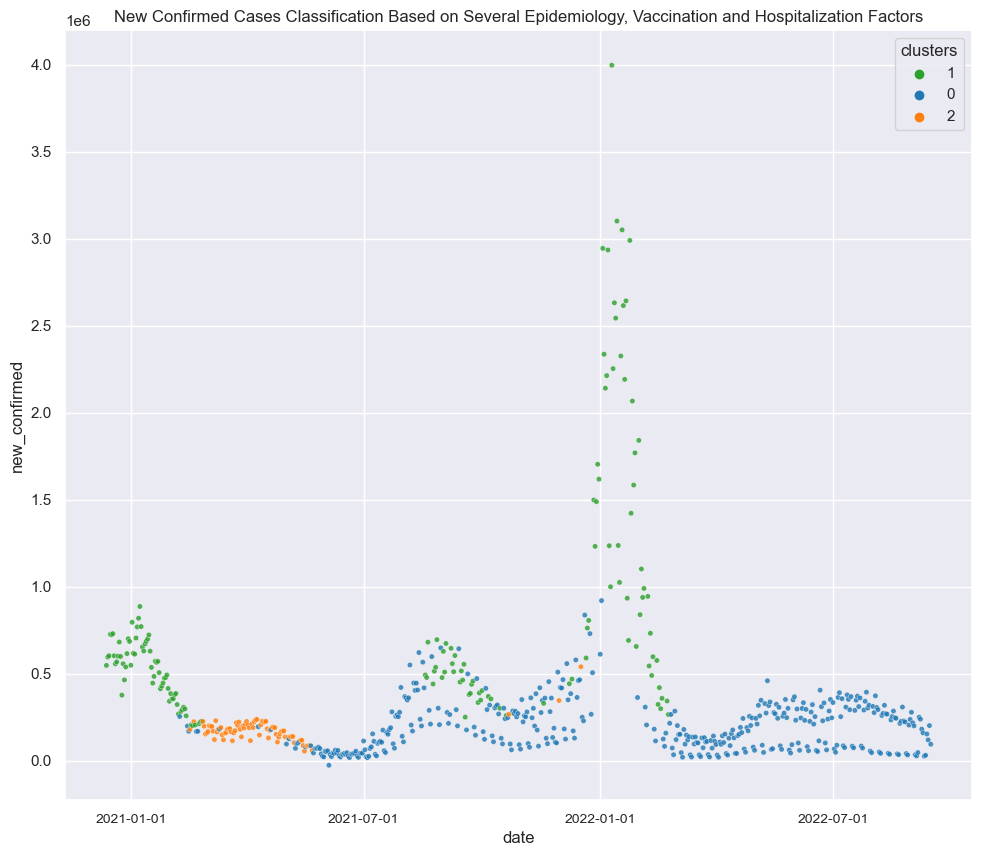

In [94]:
# predictions plot
palette = {
    '0': 'tab:blue',
    '1': 'tab:green',
    '2': 'tab:orange',
    #'3': 'tab:red',
}
sns.scatterplot(data = pred_df_k3, x='date', y='new_confirmed', hue='clusters', palette=palette, s=15, alpha=0.8)
sns.set(rc={'figure.figsize':(11.7,10.0)})
plt.xticks(['2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01'], fontsize=10)
plt.title('New Confirmed Cases Classification Based on Several Epidemiology, Vaccination and Hospitalization Factors')

Text(0.5, 1.0, 'True Clustering for New Confirmed Case Amounts')

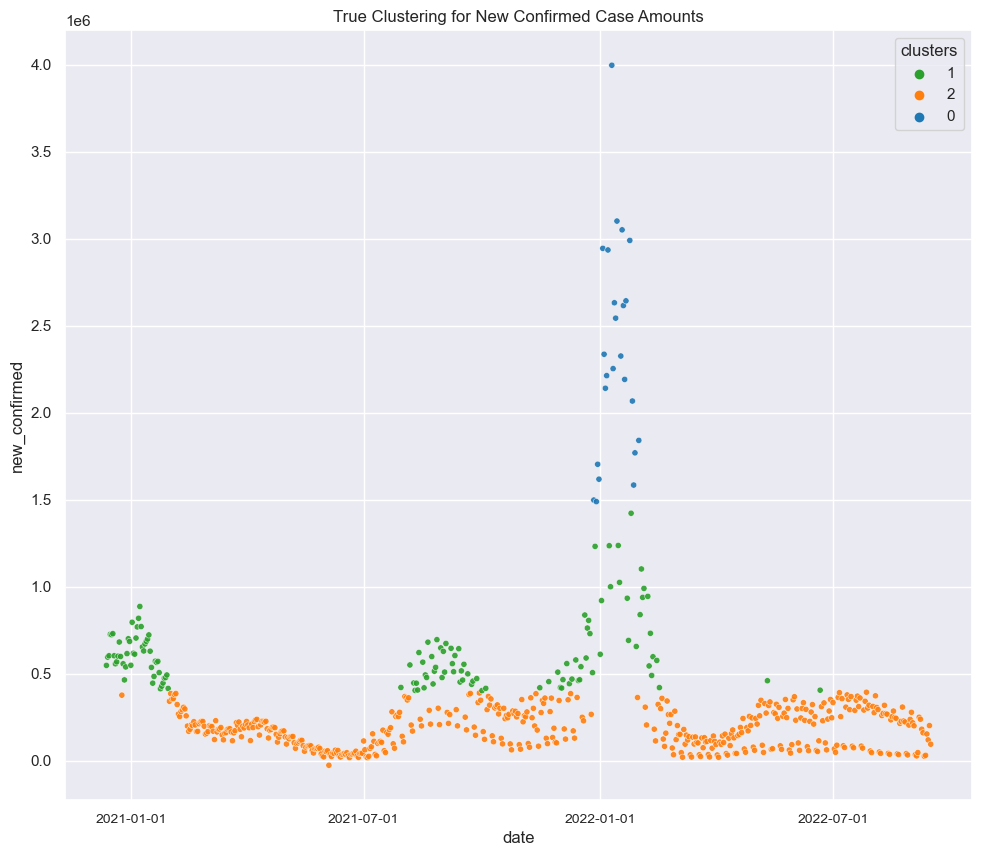

In [95]:
palette = {
    '0': 'tab:blue',
    '1': 'tab:green',
    '2': 'tab:orange',
    #'3': 'tab:red',
}
# this plot is important
sns.scatterplot(data = true_df_k3, x='date', y='new_confirmed', hue='clusters', palette=palette, s=20, alpha=0.9)
sns.set(rc={'figure.figsize':(11.7,10.0)})
plt.xticks(['2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01'], fontsize=10)
plt.title('True Clustering for New Confirmed Case Amounts')

## 6) Model Evaluations (Accuracy)

In [ ]:
covid_st_only_df

In [ ]:
covid_stringency_final_df

In [ ]:
true_df = covid_st_only_df
pred_df = covid_stringency_final_df

In [ ]:
pred_df['clusters'] = pred_df['clusters'].replace(['2'], 'A')
pred_df['clusters'] = pred_df['clusters'].replace(['1'], 'B')
pred_df['clusters'] = pred_df['clusters'].replace(['A'], '1')
pred_df['clusters'] = pred_df['clusters'].replace(['B'], '2')

In [ ]:
# predictions graph, but recoded to match 'true' labels
sns.scatterplot(data = pred_df, x='date', y='new_confirmed', hue='clusters', palette=palette, s=20, alpha=0.9)
sns.set(rc={'figure.figsize':(11.7,10.0)})
plt.xticks(['2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01'], fontsize=10)
plt.title('New Confirmed Cases Classification Based on Several Epidemiology, Vaccination and Hospitalization Factors')

In [ ]:
eval_dict = {'pred_cluster_id': pred_df['clusters'],'true_cluster_id': true_df['clusters']}
eval_df = pd.DataFrame(eval_dict)
eval_df['match'] = eval_df['pred_cluster_id'] == eval_df['true_cluster_id']
np.sum(eval_df['match']) / eval_df.shape[0]

In [ ]:
eval_df

## 7) Elbow Plots (for different Ks)

In [ ]:
# Not used currently!!!
# create_objectives_plot: plot objective values over iterations
# inputs: objective values from K means and title of the plot
# output: the plot itself
def create_objectives_plot(objectives, title):
    objective = objectives[len(objectives)-1]
    index_len = len(objectives) + 1
    index = list(range(1, index_len))
    plt.scatter(index, objectives)
    plt.title(str(round(objective, 1)) + " : "+ title)
    plt.xlabel("Iterations")
    plt.ylabel("Objective Score")
    return plt.plot(index, objectives)

In [ ]:
# making the elbow plot
ks = []
last_objs = []
for i in range(2, 15):
    k = i
    print(k)
    rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,covid_mtx.shape[1])) # 4x4 currently
    k_means_results = run_k_means(covid_mtx, rand_means, k)
    clusters, means, objectives = k_means_results
    best_obj = objectives[len(objectives)-1]
    for trial in range(9):
        rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,covid_mtx.shape[1])) # 4x4 currently
        k_means_results = run_k_means(covid_mtx, rand_means, k)
        clusters, means, objectives = k_means_results
        curr_obj = objectives[len(objectives)-1]
        if curr_obj < best_obj:
            best_obj = curr_obj
    ks.append(k)
    last_objs.append(best_obj)

In [ ]:
plt.scatter(ks, last_objs)
plt.xlabel('K Value')
plt.ylabel('Converged Objective Score')
plt.title('Objective Elbow Plot for K=2...14')
plt.xticks(range(2, 15))
plt.plot(ks, last_objs)

## 8) Extra: k = 7 clusters

In [ ]:
covid_norm_df_nonan = covid_norm_df[covid_norm_df.index.isin(merged_final_df.index.values.tolist())]
# for k means
covid_mtx = covid_norm_df_nonan.to_numpy()
date_list = covid_norm_df_nonan.index.tolist()
# covid_mtx
# covid_mtx2 = covid_mtx[~np.isnan(covid_mtx[:,1])]
# date_list = covid_norm_df_nonan.index.tolist()
# date_list2 = np.array(date_list)[~np.isnan(covid_mtx[:,1])]
k = 7
rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,covid_mtx.shape[1])) # 4x4 currently

k_means_results = run_k_means(covid_mtx, rand_means, k)
clusters = k_means_results[0]

# clusters = k_means_results[0]
# countries = covid_norm_df.index.tolist()
# mini_idx_df = idx_df[['location_key', 'country_name']]
d = {'date': date_list,'clusters': clusters}
clustered_dates_df = pd.DataFrame(d)
#clustered_countries_name_df = (clustered_countries_df.merge(mini_idx_df, on='location_key', how='inner'))
# clustered_countries_name_df

In [ ]:
# for stringency stuff
covid_stringency_df = covid_merged_df[['new_confirmed']]
covid_stringency_agg_df  = covid_stringency_df.groupby(['date']).sum()
#covid_stringency_final_df = covid_stringency_agg_df[~np.isnan(covid_mtx[:,1])]
covid_stringency_final_df = covid_stringency_agg_df[covid_norm_df.index.isin(merged_final_df.index.values.tolist())]

#covid_c_s_agg = covid_agg_selected.groupby(['date']).sum()
covid_stringency_final_df['clusters'] = (clustered_dates_df['clusters'].values).astype(str)
covid_stringency_final_df

In [ ]:
# this plot is important
palette = {
    '0': 'tab:purple',
    '1': 'tab:blue',
    '2': 'tab:green',
    '3': 'tab:orange',
    '4': 'tab:red',
    '5': 'tab:pink',
    '6': 'tab:brown',
}

#covid_c_s_agg = covid_agg_selected.groupby(['date']).sum()
covid_stringency_final_df['clusters'] = (clustered_dates_df['clusters'].values).astype(str)
covid_stringency_final_df
sns.scatterplot(data = covid_stringency_final_df, x='date', y='new_confirmed', hue='clusters', palette=palette, s=15, alpha=1.0)
sns.set(rc={'figure.figsize':(11.7,10.0)})
plt.xticks(['2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01'], fontsize=10)
plt.title('New Confirmed Cases Classification Based on Several Epidemiology, Vaccination and Hospitalization Factors')

In [ ]:
covid_norm_df.index.isin(merged_final_df.index.values.tolist())
covid_st_only_df = covid_stringency_only_df[covid_norm_df.index.isin(merged_final_df.index.values.tolist())]
covid_st_only_df.head(3)
st_mtx = covid_st_only_df.to_numpy()
date_list = covid_st_only_df.index.tolist()
#date_list2 = np.array(date_list)[~np.isnan(covid_mtx[:,1])]
k = 7
rand_means = np.random.uniform(low=-3.0, high=3.0, size=(k,covid_mtx.shape[1])) # 4x4 currently

k_means_results = run_k_means(st_mtx, rand_means, k)
clusters = k_means_results[0]
# clusters

# date_list2

# clusters = k_means_results[0]
# countries = covid_norm_df.index.tolist()
# mini_idx_df = idx_df[['location_key', 'country_name']]
d = {'date': date_list,'clusters': clusters}
st_clustered_dates_df = pd.DataFrame(d)
#clustered_countries_name_df = (clustered_countries_df.merge(mini_idx_df, on='location_key', how='inner'))
# clustered_countries_name_df
covid_st_only_df['clusters'] = (st_clustered_dates_df['clusters'].values).astype(str)
covid_st_only_df

In [ ]:
# this plot is important
palette = {
    '0': 'tab:purple',
    '1': 'tab:blue',
    '2': 'tab:green',
    '3': 'tab:orange',
    '4': 'tab:red',
    '5': 'tab:pink',
    '6': 'tab:brown',
}
sns.scatterplot(data = covid_st_only_df, x='date', y='new_confirmed', hue='clusters', palette=palette, s=15, alpha=1.0)
sns.set(rc={'figure.figsize':(11.7,10.0)})
plt.xticks(['2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01'], fontsize=10)
plt.title('True Clustering for New Confirmed Case Amounts')

In [ ]:
cluster_means_pred_df = covid_stringency_final_df.groupby(['clusters']).mean()
cluster_means_pred_df.sort_values(by=['new_confirmed'], ascending=False)

In [ ]:
pred_df = covid_stringency_final_df
true_df = covid_st_only_df

In [ ]:
pred_df['clusters'] = pred_df['clusters'].replace(['0'], 'A')
pred_df['clusters'] = pred_df['clusters'].replace(['1'], 'B')
pred_df['clusters'] = pred_df['clusters'].replace(['2'], 'C')
pred_df['clusters'] = pred_df['clusters'].replace(['3'], 'D')
pred_df['clusters'] = pred_df['clusters'].replace(['4'], 'E')
pred_df['clusters'] = pred_df['clusters'].replace(['5'], 'F')
pred_df['clusters'] = pred_df['clusters'].replace(['6'], 'G')

pred_df['clusters'] = pred_df['clusters'].replace(['A'], '2')
pred_df['clusters'] = pred_df['clusters'].replace(['B'], '0')
pred_df['clusters'] = pred_df['clusters'].replace(['C'], '6')
pred_df['clusters'] = pred_df['clusters'].replace(['D'], '4')
pred_df['clusters'] = pred_df['clusters'].replace(['E'], '5')
pred_df['clusters'] = pred_df['clusters'].replace(['F'], '3')
pred_df['clusters'] = pred_df['clusters'].replace(['G'], '1')

In [ ]:
# this plot is important
palette = {
    '0': 'tab:purple',
    '1': 'tab:blue',
    '2': 'tab:green',
    '3': 'tab:orange',
    '4': 'tab:red',
    '5': 'tab:pink',
    '6': 'tab:brown',
}
sns.scatterplot(data = pred_df, x='date', y='new_confirmed', hue='clusters', palette=palette, s=15, alpha=1.0)
sns.set(rc={'figure.figsize':(11.7,10.0)})
plt.xticks(['2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01'], fontsize=10)
plt.title('New Confirmed Cases Classification Based on Several Epidemiology, Vaccination and Hospitalization Factors')

In [ ]:
eval_dict = {'pred_cluster_id': pred_df['clusters'],'true_cluster_id': true_df['clusters']}
eval_df = pd.DataFrame(eval_dict)
eval_df['match'] = eval_df['pred_cluster_id'] == eval_df['true_cluster_id']
np.sum(eval_df['match']) / eval_df.shape[0]